In [2]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('cancer_reg.csv')

## EDA



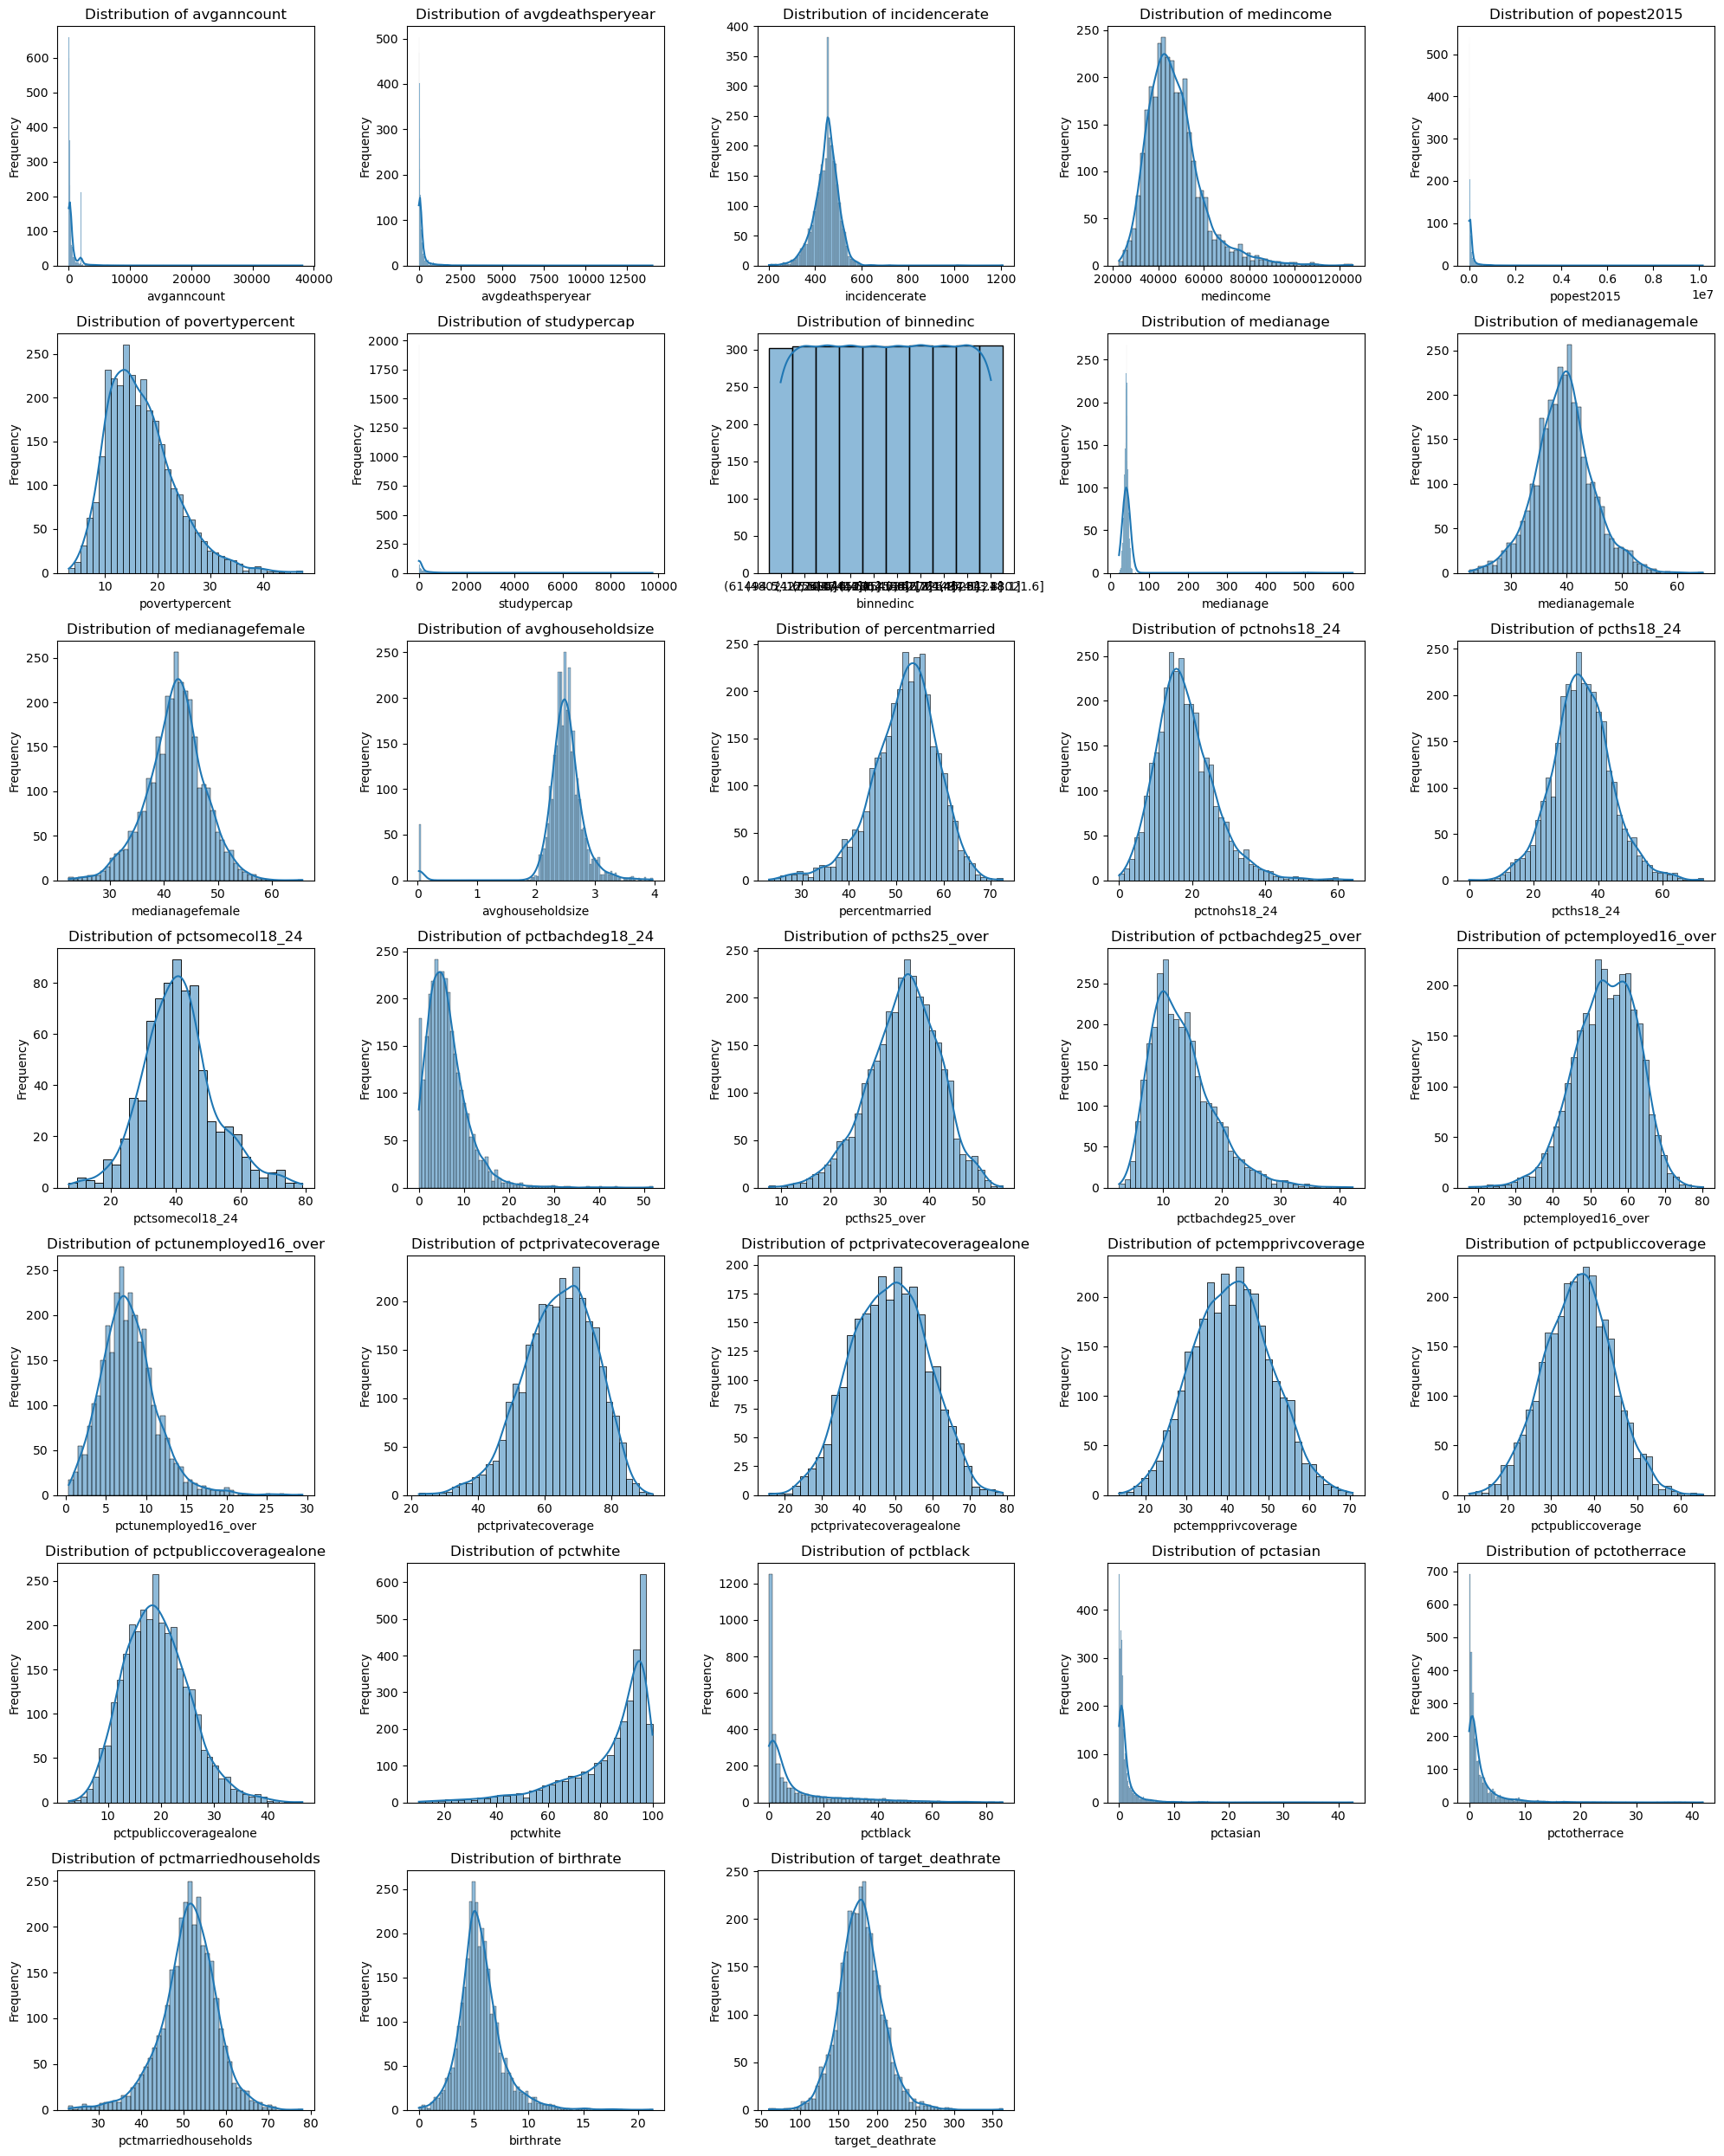

In [5]:
columns = ['avganncount', 'avgdeathsperyear', 'incidencerate',
           'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
           'medianage', 'medianagemale', 'medianagefemale', 'avghouseholdsize',
           'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctsomecol18_24',
           'pctbachdeg18_24', 'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
           'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
           'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
           'pctwhite', 'pctblack', 'pctasian', 'pctotherrace', 'pctmarriedhouseholds',
           'birthrate']

target = 'target_deathrate'

plt.figure(figsize=(20, 25))
for i, col in enumerate(columns+['target_deathrate'], 1):
    plt.subplot(7, 5, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

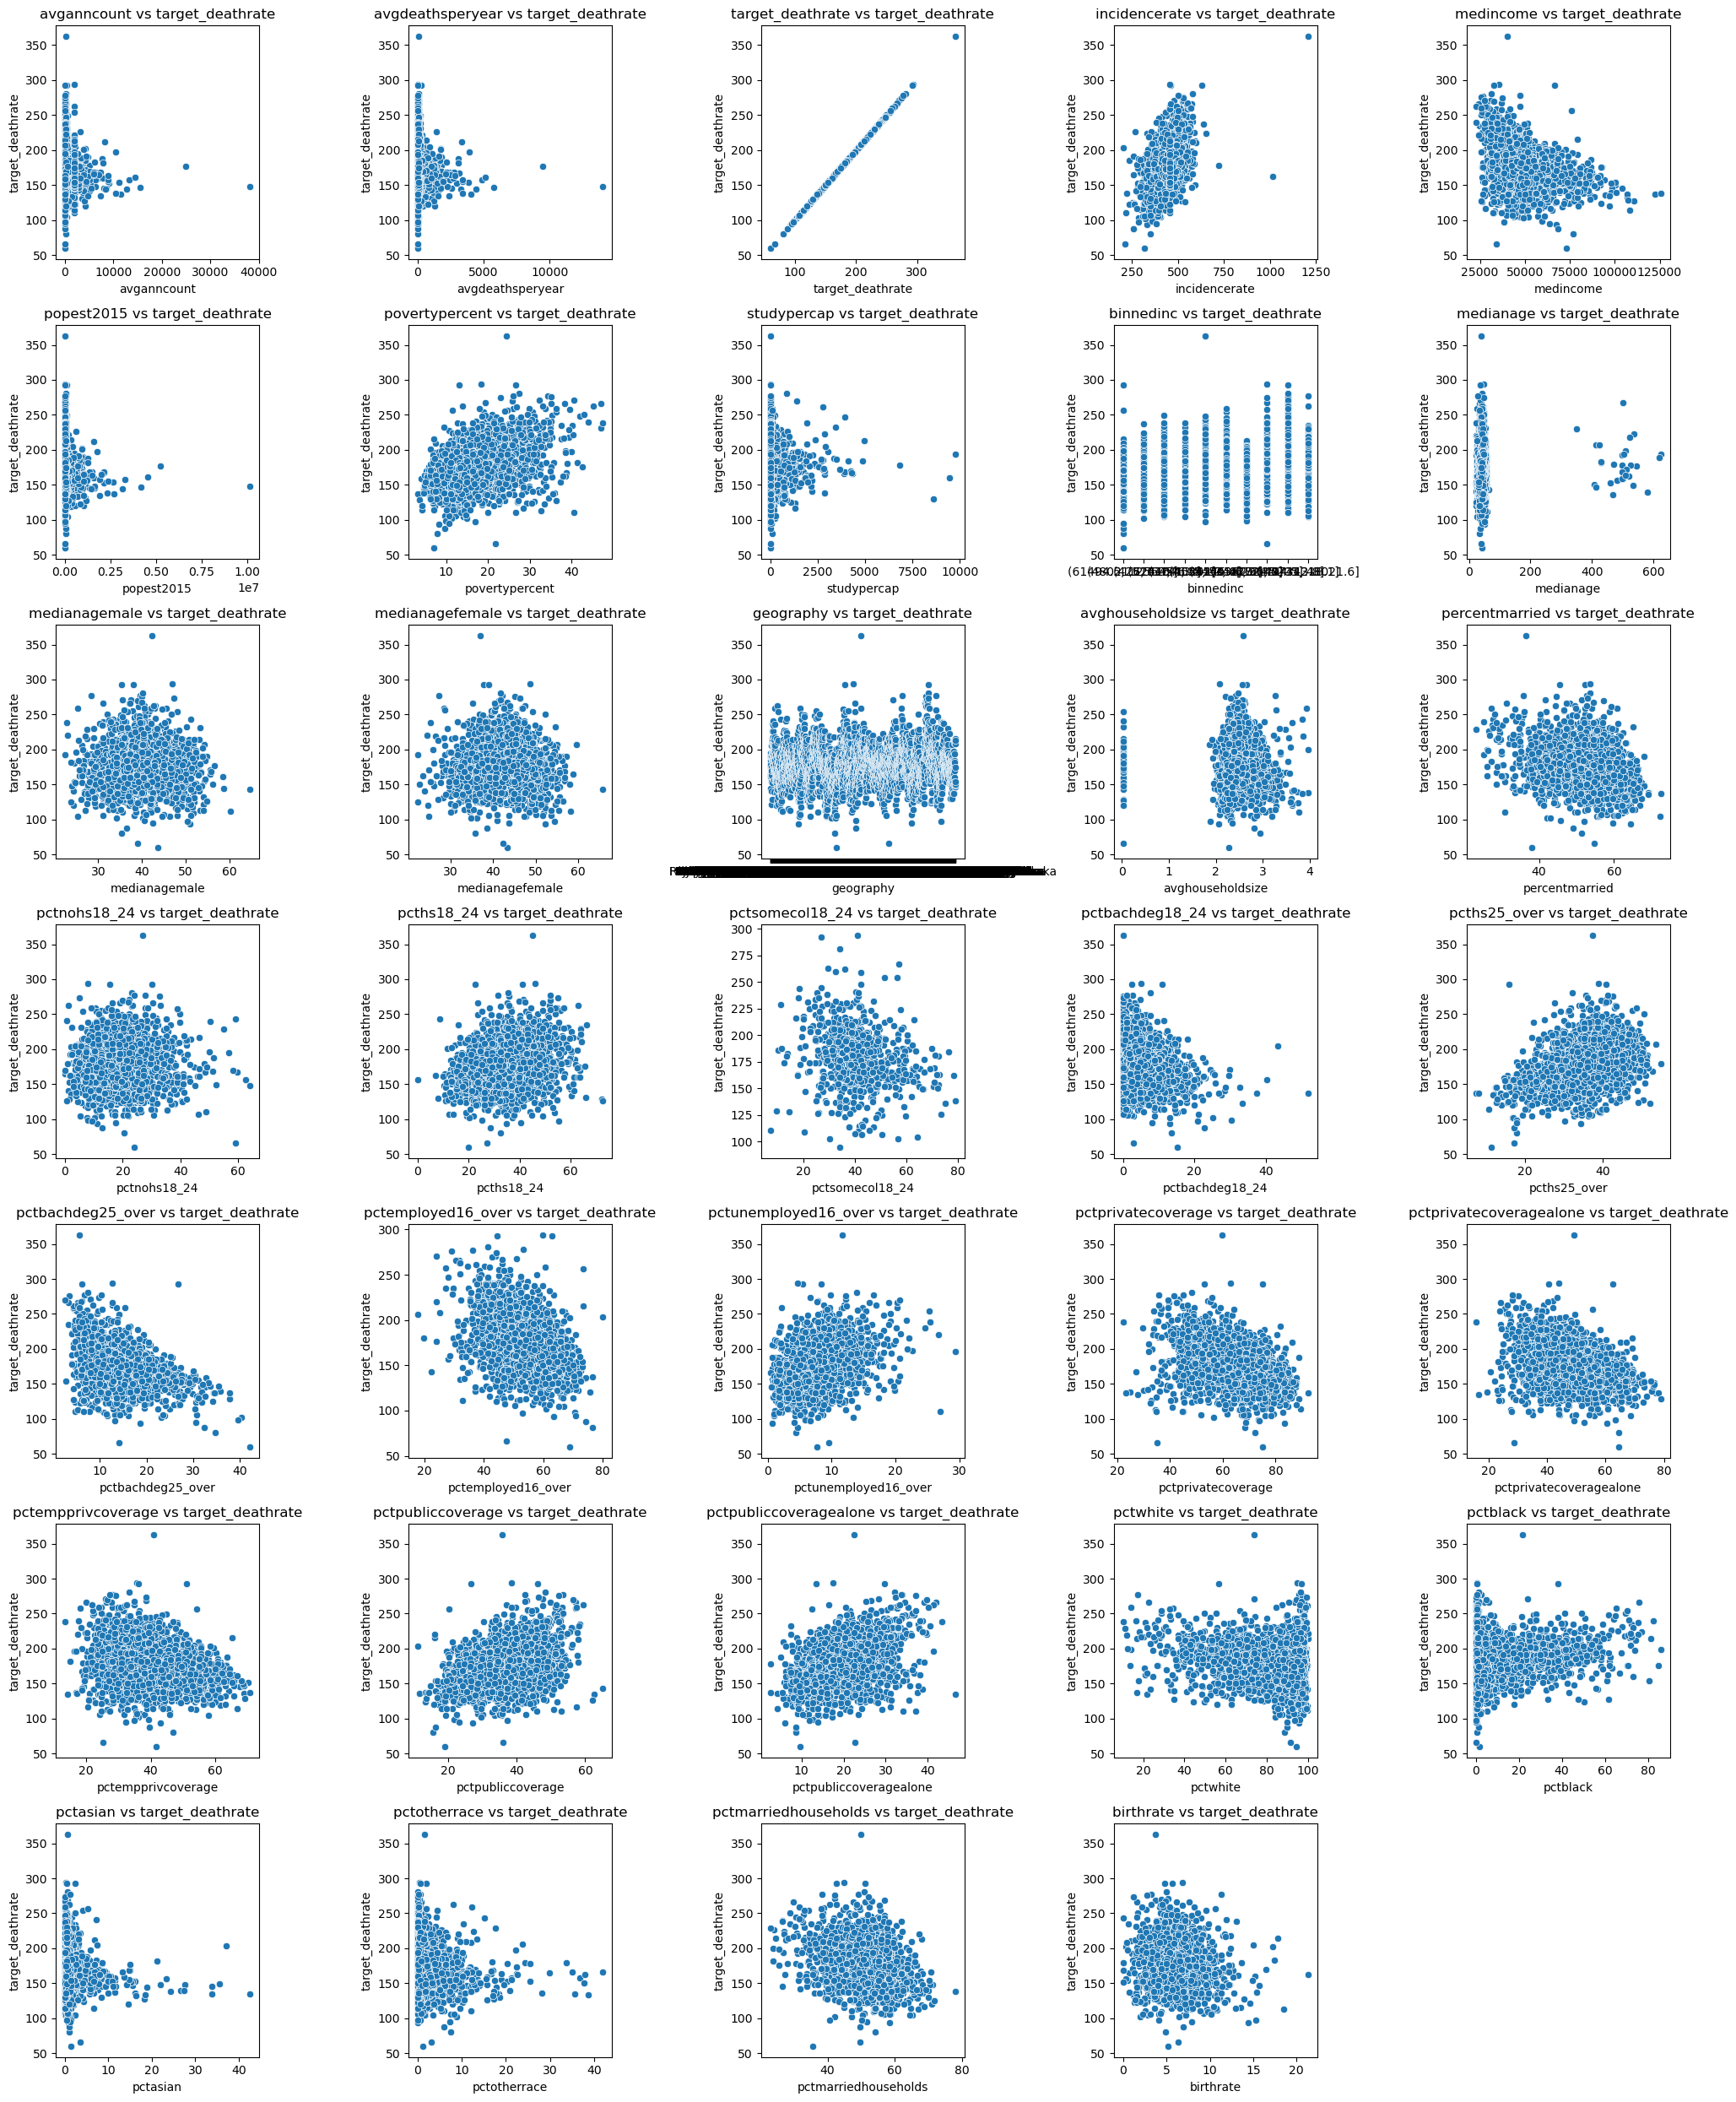

In [6]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(df.columns, 1):
    plt.subplot(7, 5, i)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f'{col} vs {target}')
    plt.xlabel(col)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

In [7]:
df['avganncount'].quantile([.001,.01,.1,0.99,.999]), df['avganncount'].min(), df['avganncount'].max()

(0.001        7.046
 0.010       11.000
 0.100       37.000
 0.990     5932.920
 0.999    14422.582
 Name: avganncount, dtype: float64,
 6.0,
 38150.0)

In [8]:
df['avganncount_new'] = df['avganncount'].clip(upper=15000)
df['medianage'] = df['medianage'].apply(lambda x: x if x<150 else df['medianage'].mean())

In [9]:
df['pctemployed16_over'].fillna(df['pctemployed16_over'].median(), inplace=True)
df['pctprivatecoveragealone'].fillna(df['pctprivatecoveragealone'].mean(), inplace=True)
df['pctsomecol18_24'].fillna(df['pctsomecol18_24'].median(), inplace=True)

In [10]:
census_region_to_state = {
    "Northeast": [
        "Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont",
        "New Jersey", "New York", "Pennsylvania"
    ],
    "Midwest": [
        "Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin",
        "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"
    ],
    "South": [
        "Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "West Virginia",
        "District of Columbia",
        "Alabama", "Kentucky", "Mississippi", "Tennessee",
        "Arkansas", "Louisiana", "Oklahoma", "Texas"
    ],
    "West": [
        "Alaska", "California", "Hawaii", "Oregon", "Washington",
        "Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming"
    ]
}

def get_region(state):
    for region, states in census_region_to_state.items():
        if state in states:
            return region
    # print(state)
    return None

df['geo_region'] = df['geography'].apply(lambda x: get_region(x.split(',')[1][1:]))

In [11]:
df['binnedinc_lower']=pd.to_numeric(df['binnedinc'].apply(lambda x: x.split(',')[0][1:]))
df['binnedinc_upper']=pd.to_numeric(df['binnedinc'].apply(lambda x: x.split(',')[1][:-1]))
df['avghouseholdsize_category'] = pd.qcut(df['avghouseholdsize'], q=3, labels=['Low','Med','High']).astype('category')
col = 'medincome'
col_cat = 'medincome_category'

quantiles = df[col].quantile([0.3, 0.7, 0.98])

bins = [df[col].min()] + list(quantiles) + [df[col].max()]

labels = ['Low', 'Med', 'High', 'VeryHigh']

df[col_cat] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)

## Multicollinearity 

#### Correlation

In [12]:
df = pd.get_dummies(df, columns=['avghouseholdsize_category', 'medincome_category', 'geo_region'], drop_first=True).drop(['binnedinc', 'geography', 'avganncount', 'avghouseholdsize', 'medincome'], axis=1)
corr_dict = {}
for col in list(df.columns):
    corr = df[col].corr(df['target_deathrate'])
    corr_type = ""
    abs_corr = np.abs(corr)
    if abs_corr < .25:
        corr_type = "weak"
    elif abs_corr >= .7:
        corr_type = 'strong'
    elif abs_corr >= .25 and abs_corr < .7:
        corr_type = "medium"
    corr_dict[col] = {'corr':corr, 'strength': corr_type}

    # print(f"{col} correlation with deathrate: {corr} {corr_type}")
corr_df = pd.DataFrame(corr_dict).T.sort_values(by=['corr'], ascending=False)
corr_df

corr strength
target_deathrate                     1.0   strong
incidencerate                   0.449432   medium
pctpubliccoveragealone          0.449358   medium
povertypercent                  0.429389   medium
pcths25_over                    0.404589   medium
pctpubliccoverage               0.404572   medium
pctunemployed16_over            0.378412   medium
geo_region_South                0.338126   medium
pcths18_24                      0.261976   medium
pctblack                        0.257024   medium
avghouseholdsize_category_Med   0.168061     weak
pctnohs18_24                    0.088463     weak
medianagefemale                 0.012048     weak
medianage                      -0.003764     weak
medianagemale                  -0.021929     weak
studypercap                    -0.022285     weak
medincome_category_Med         -0.031787     weak
geo_region_Northeast           -0.061249     weak
avghouseholdsize_category_High -0.065244     weak
birthrate                      -0.087407     weak
avgdeathsperyear               -0.090715     weak
pctsomecol18_24                -0.094901     weak
popest2015                     -0.120073     weak
medincome_category_VeryHigh    -0.145424     weak
avganncount_new                -0.159989     weak
pctwhite                         -0.1774     weak
pctasian                       -0.186331     weak
pctotherrace                   -0.189894     weak
percentmarried                  -0.26682   medium
pctempprivcoverage             -0.267399   medium
pctbachdeg18_24                -0.287817   medium
medincome_category_High        -0.289268   medium
pctmarriedhouseholds           -0.293325   medium
geo_region_West                -0.296266   medium
pctprivatecoveragealone        -0.326067   medium
binnedinc_upper                -0.337185   medium
pctprivatecoverage             -0.386066   medium
pctemployed16_over             -0.397433   medium
binnedinc_lower                -0.448056   medium
pctbachdeg25_over              -0.485477   medium

#### VIF

In [13]:
X = df[['medianage', 'medianagemale', 'medianagefemale']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Feature'] = X.columns
print(vif)

           VIF          Feature
0  3100.500922        medianage
1  1335.697619    medianagemale
2  1129.908864  medianagefemale


In [14]:
X = df[['pctnohs18_24', 'pcths18_24', 'pctsomecol18_24', 'pctbachdeg18_24', 'pcths25_over' ,'pctbachdeg25_over']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Feature'] = X.columns
print(vif)

         VIF            Feature
0   6.338839       pctnohs18_24
1  20.004559         pcths18_24
2  38.625694    pctsomecol18_24
3   5.013162    pctbachdeg18_24
4  42.697223       pcths25_over
5  15.445700  pctbachdeg25_over


In [15]:
X = df[['pctwhite', 'pctblack', 'pctasian', 'pctotherrace']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Feature'] = X.columns
print(vif)

        VIF       Feature
0  1.455521      pctwhite
1  1.195237      pctblack
2  1.252887      pctasian
3  1.328156  pctotherrace


In [16]:
X = df[['pctemployed16_over', 'pctunemployed16_over']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Feature'] = X.columns
print(vif)

       VIF               Feature
0  4.04912    pctemployed16_over
1  4.04912  pctunemployed16_over


TODO: Explore Interaction Terms

> dropping 'medianagemale', 'medianagefemale', 'pcths18_24', 'pctsomecol18_24', 'pcths25_over' ,'pctbachdeg25_over' due to high VIF score

In [18]:
df = df.drop(['medianagemale', 'medianagefemale', 'pcths18_24', 'pctsomecol18_24', 'pcths25_over' ,'pctbachdeg25_over'], axis=1)

#### Influential points 

In [19]:
df.columns

Index(['avgdeathsperyear', 'target_deathrate', 'incidencerate', 'popest2015',
       'povertypercent', 'studypercap', 'medianage', 'percentmarried',
       'pctnohs18_24', 'pctbachdeg18_24', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'avganncount_new',
       'binnedinc_lower', 'binnedinc_upper', 'avghouseholdsize_category_Med',
       'avghouseholdsize_category_High', 'medincome_category_Med',
       'medincome_category_High', 'medincome_category_VeryHigh',
       'geo_region_Northeast', 'geo_region_South', 'geo_region_West'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   avgdeathsperyear                3047 non-null   int64  
 1   target_deathrate                3047 non-null   float64
 2   incidencerate                   3047 non-null   float64
 3   popest2015                      3047 non-null   int64  
 4   povertypercent                  3047 non-null   float64
 5   studypercap                     3047 non-null   float64
 6   medianage                       3047 non-null   float64
 7   percentmarried                  3047 non-null   float64
 8   pctnohs18_24                    3047 non-null   float64
 9   pctbachdeg18_24                 3047 non-null   float64
 10  pctemployed16_over              3047 non-null   float64
 11  pctunemployed16_over            3047 non-null   float64
 12  pctprivatecoverage              30

In [21]:
df.columns

Index(['avgdeathsperyear', 'target_deathrate', 'incidencerate', 'popest2015',
       'povertypercent', 'studypercap', 'medianage', 'percentmarried',
       'pctnohs18_24', 'pctbachdeg18_24', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'avganncount_new',
       'binnedinc_lower', 'binnedinc_upper', 'avghouseholdsize_category_Med',
       'avghouseholdsize_category_High', 'medincome_category_Med',
       'medincome_category_High', 'medincome_category_VeryHigh',
       'geo_region_Northeast', 'geo_region_South', 'geo_region_West'],
      dtype='object')

In [22]:
# Initial fit

model = smf.ols('target_deathrate ~ avgdeathsperyear + incidencerate + popest2015+ \
       povertypercent + studypercap + medianage + percentmarried+ \
       pctnohs18_24 + pctbachdeg18_24 + pctemployed16_over+ \
       pctunemployed16_over + pctprivatecoverage + pctprivatecoveragealone+ \
       pctempprivcoverage + pctpubliccoverage + pctpubliccoveragealone+ \
       pctwhite + pctblack + pctasian + pctotherrace+ \
       pctmarriedhouseholds + birthrate + avganncount_new+ \
       binnedinc_lower + binnedinc_upper + avghouseholdsize_category_Med+ \
       avghouseholdsize_category_High + medincome_category_Med+ \
       medincome_category_High + medincome_category_VeryHigh+ \
       geo_region_Northeast + geo_region_South + geo_region_West', data=df).fit()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       target_deathrate   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     102.3
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:00:40   Log-Likelihood:                -13304.
No. Observations:                3047   AIC:                         2.668e+04
Df Residuals:                    3013   BIC:                         2.688e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                203.1137     16.273     12.482      0.000     171.207     235.021
avghouseholdsize_category_Med[T.True]      4.6992      0.976      4.815      0.000       2.786       6.613
avghouseholdsize_category_High[T.True]     4.2945      1.316      3.263      0.001       1.714       6.875
medincome_category_Med[T.True]            -0.6317      1.392     -0.454      0.650      -3.362       2.098
medincome_category_High[T.True]           -0.3674      2.116     -0.174      0.862      -4.517       3.783
medincome_category_VeryHigh[T.True]       -3.0620      3.716     -0.824      0.410     -10.348       4.224
geo_region_Northeast[T.True]              -8.4125      1.620     -5.192      0.000     -11.589      -5.236
geo_region_South[T.True]                   2.5802      1.131      2.281      0.023       0.363       4.798
geo_region_West[T.True]                  -15.0709      1.321    -11.408      0.000     -17.661     -12.480
avgdeathsperyear                           0.0177      0.004      4.540      0.000       0.010       0.025
incidencerate                              0.1998      0.007     27.653      0.000       0.186       0.214
popest2015                             -1.838e-05   5.49e-06     -3.350      0.001   -2.91e-05   -7.62e-06
povertypercent                            -0.4836      0.174     -2.779      0.005      -0.825      -0.142
studypercap                               -0.0006      0.001     -0.969      0.333      -0.002       0.001
medianage                                 -0.3948      0.145     -2.718      0.007      -0.680      -0.110
percentmarried                             1.0597      0.171      6.182      0.000       0.724       1.396
pctnohs18_24                              -0.0904      0.055     -1.657      0.098      -0.197       0.017
pctbachdeg18_24                           -0.6189      0.103     -5.991      0.000      -0.821      -0.416
pctemployed16_over                        -0.6452      0.102     -6.328      0.000      -0.845      -0.445
pctunemployed16_over                       0.2213      0.165      1.337      0.181      -0.103       0.546
pctprivatecoverage                        -0.6397      0.142     -4.501      0.000      -0.918      -0.361
pctprivatecoveragealone                    0.0421      0.084      0.502      0.616      -0.122       0.207
pctempprivcoverage                         0.6440      0.100      6.456      0.000       0.448       0.840
pctpubliccoverage                          0.1803      0.223      0.810      0.418      -0.256       0.617
pctpubliccoveragealone                     0.3331      0.276      1.205      0.228      -0.209       0.875
pctwhite                                  -0.2313      0.056     -4.094      0.000     

In [24]:
infl = model.get_influence()
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/len(df)
print(df.index[atyp_cook])

Index([  29,   30,   97,  104,  111,  115,  116,  117,  118,  119,
       ...
       2802, 2808, 2810, 2813, 2818, 2821, 3033, 3035, 3039, 3046],
      dtype='int64', length=202)


In [25]:
df.loc[df.index[atyp_cook]]

avgdeathsperyear  target_deathrate  incidencerate  popest2015  \
29                  26             212.9     591.000000        8910   
30                  19             185.6     234.000000        8176   
97                  25             166.4     490.600000        9057   
104                 13             120.2     432.500000        5163   
111                 62             211.0     453.549422       24200   
...                ...               ...            ...         ...   
2821                 5             143.0     521.400000        2355   
3033                 7             209.6     453.549422        1843   
3035                13             214.7     453.549422        2932   
3039                 9             208.3     453.549422        2968   
3046                48             213.6     453.549422       37030   

      povertypercent  studypercap  medianage  percentmarried  pctnohs18_24  \
29              25.1  4938.271605       43.3            55.8          19.5   
30              17.4     0.000000       43.7            45.8          26.2   
97              17.0  4306.061610       45.3            52.8          18.9   
104             10.7     0.000000       48.9            67.0          21.5   
111             13.2     0.000000       38.9            51.6          19.8   
...              ...          ...        ...             ...           ...   
2821            14.7     0.000000       46.8            61.8           6.8   
3033            11.4     0.000000       45.7            60.2          32.2   
3035            13.9     0.000000       52.3            54.4          11.3   
3039            10.5   673.854447       45.2            60.9          16.3   
3046            13.9     0.000000       26.2            59.5           8.0   

      pctbachdeg18_24  ...  binnedinc_lower  binnedinc_upper  \
29                0.0  ...          22640.0          34218.1   
30                1.9  ...          40362.7          42724.4   
97                4.4  ...          40362.7          42724.4   
104               9.2  ...          48021.6          51046.4   
111               1.4  ...          45201.0          48021.6   
...               ...  ...              ...              ...   
2821              2.9  ...          45201.0          48021.6   
3033              5.2  ...          45201.0          48021.6   
3035             18.1  ...          40362.7          42724.4   
3039             14.4  ...          48021.6          51046.4   
3046              4.8  ...          40362.7          42724.4   

      avghouseholdsize_category_Med  avghouseholdsize_category_High  \
29                            False                            True   
30                            False                            True   
97                            False                           False   
104                           False                           False   
111                            True                           False   
...                             ...                             ...   
2821                          False                           False   
3033                           True                           False   
3035                          False                           False   
3039                          False                           False   
3046                          False                            True   

      medincome_category_Med  medincome_category_High  \
29                     False                    False   
30                      True                    False   
97                      True                    False   
104                     True                    False   
111                     True                    False   
...                      ...                      ...   
2821                    True                    False   
3033                    True                    False   
3035                    True                    False   
3039                    

## Hetrokedasticity

#### residual plot

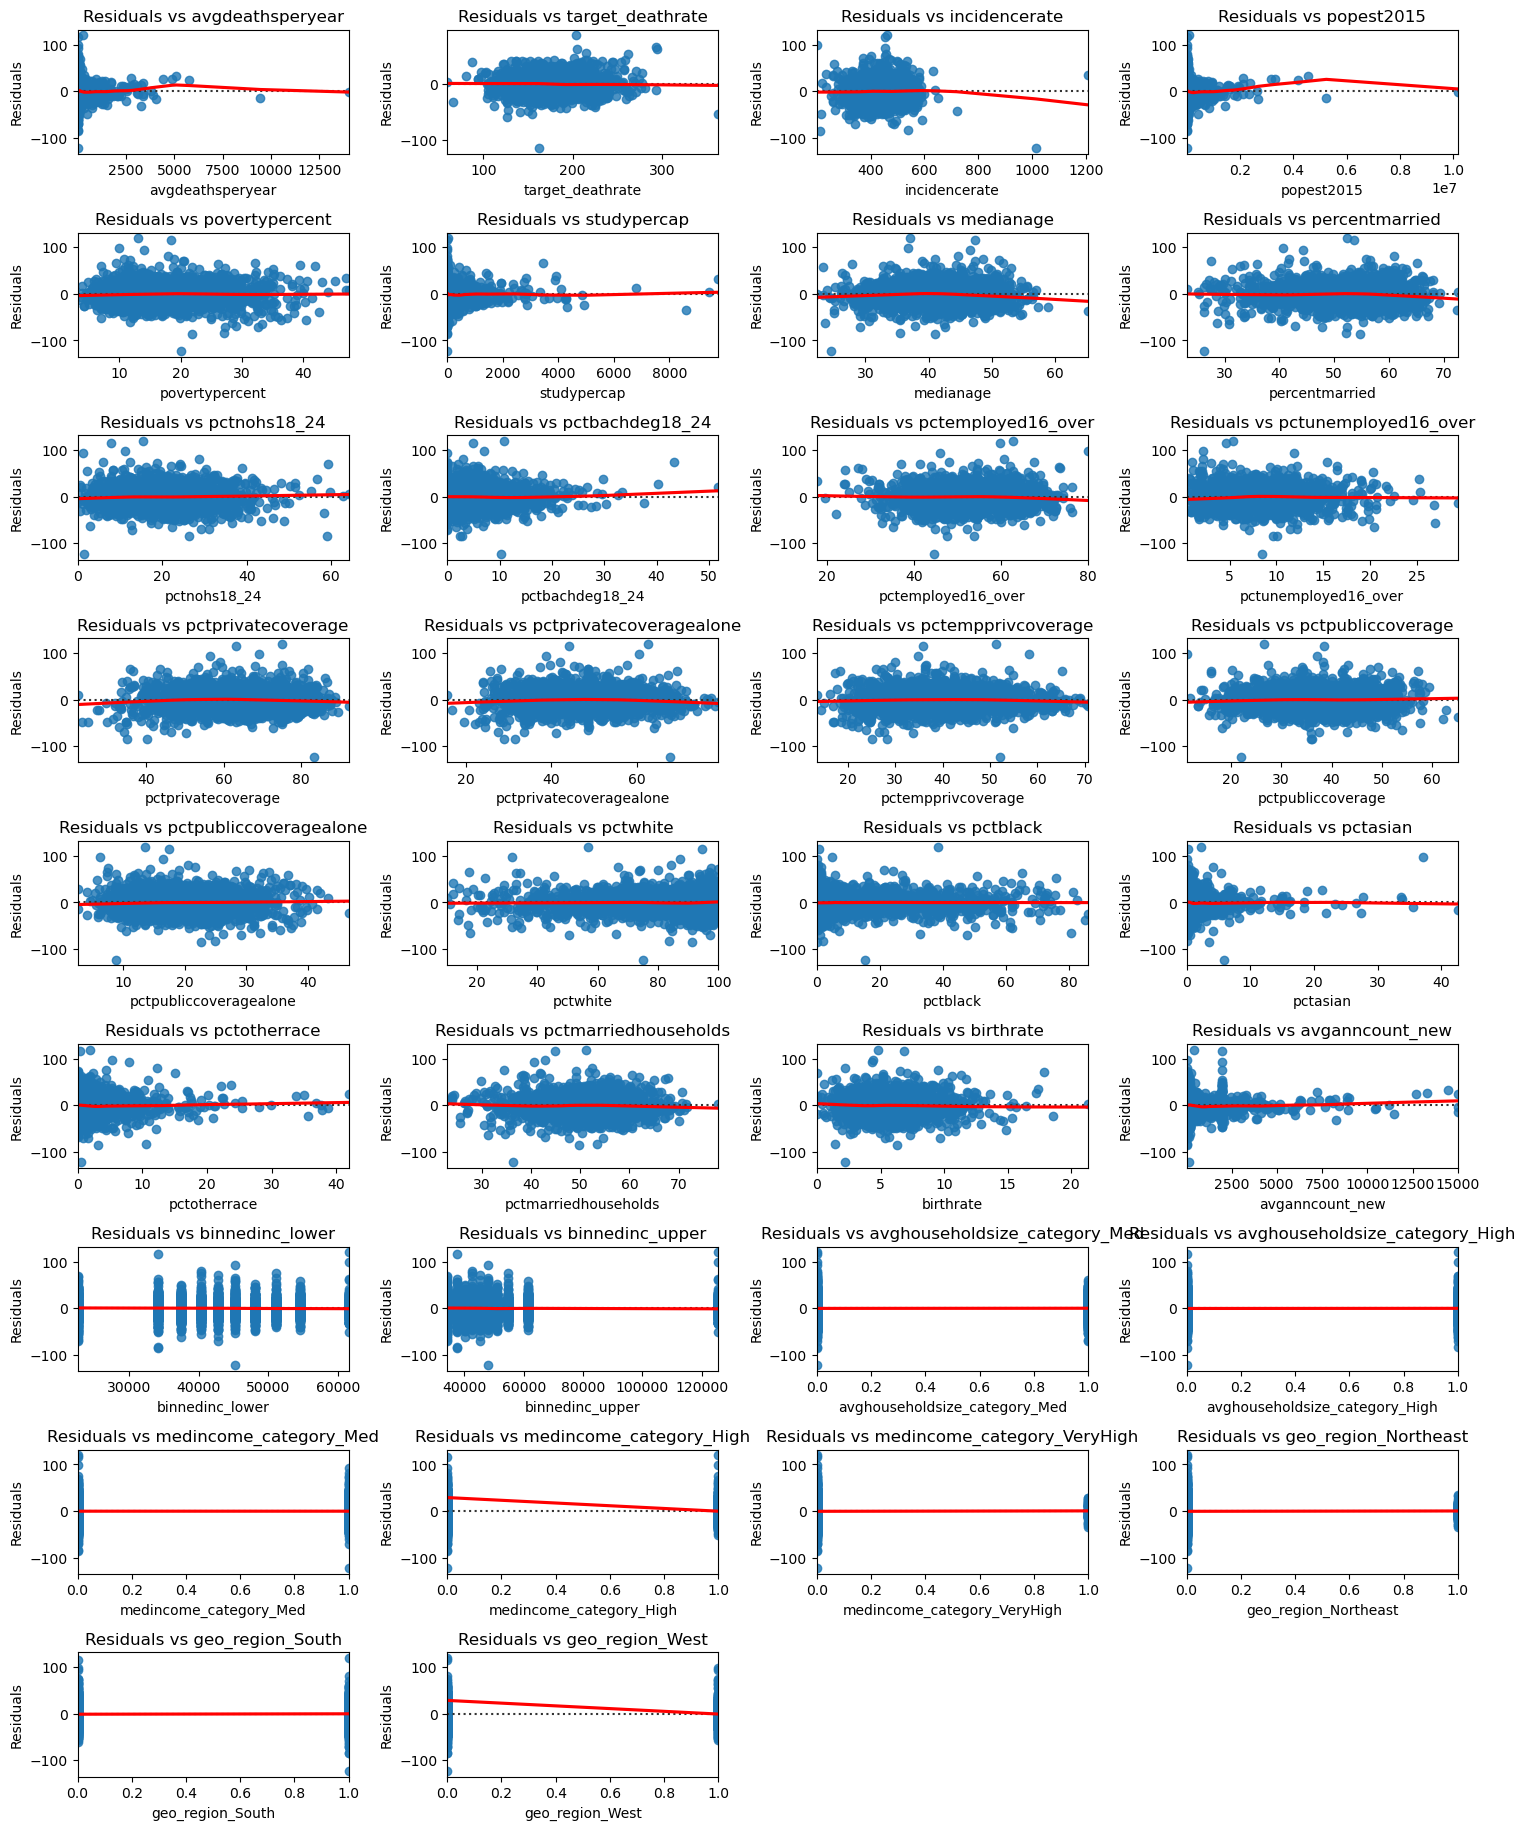

In [26]:
residuals = model.resid
predictions = model.fittedvalues


numeric_features = [feature for feature in df.columns if pd.api.types.is_numeric_dtype(df[feature])]

# Plot residuals for each numeric feature
plt.figure(figsize=(15, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(10, 4, i+1)  # Adjust grid size based on the number of features
    sns.residplot(x=df[feature], y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title(f'Residuals vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

#### Transformations

In [29]:
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [30]:
df_filtered = df.loc[~df.index.isin(df.index[atyp_cook])]

In [31]:
df_filtered.columns

Index(['avgdeathsperyear', 'target_deathrate', 'incidencerate', 'popest2015',
       'povertypercent', 'studypercap', 'medianage', 'percentmarried',
       'pctnohs18_24', 'pctbachdeg18_24', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'avganncount_new',
       'binnedinc_lower', 'binnedinc_upper', 'avghouseholdsize_category_Med',
       'avghouseholdsize_category_High', 'medincome_category_Med',
       'medincome_category_High', 'medincome_category_VeryHigh',
       'geo_region_Northeast', 'geo_region_South', 'geo_region_West'],
      dtype='object')

In [32]:
model_without_infl = smf.ols('target_deathrate ~ avgdeathsperyear + incidencerate + popest2015+ \
       povertypercent + studypercap + medianage + percentmarried+ \
       pctnohs18_24 + pctbachdeg18_24 + pctemployed16_over+ \
       pctunemployed16_over + pctprivatecoverage + pctprivatecoveragealone+ \
       pctempprivcoverage + pctpubliccoverage + pctpubliccoveragealone+ \
       pctwhite + pctblack + pctasian + pctotherrace+ \
       pctmarriedhouseholds + birthrate + avganncount_new+ \
       binnedinc_lower + binnedinc_upper + avghouseholdsize_category_Med+ \
       avghouseholdsize_category_High + medincome_category_Med+ \
       medincome_category_High + medincome_category_VeryHigh+ \
       geo_region_Northeast + geo_region_South + geo_region_West', data=df_filtered).fit()

residuals = model_without_infl.resid
predictions = model_without_infl.fittedvalues

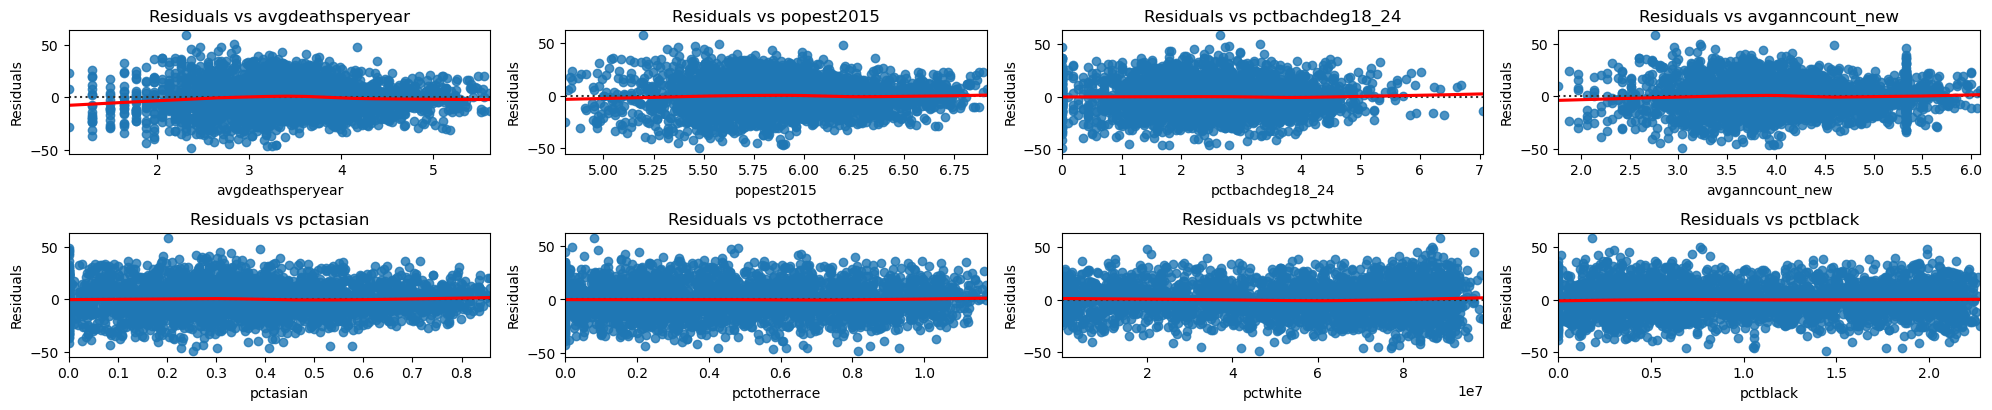

In [33]:
numeric_features = [feature for feature in ['avgdeathsperyear', 'popest2015', 'pctbachdeg18_24', 
                                'avganncount_new', 'pctasian', 'pctotherrace', 'pctwhite', 'pctblack'] 
                                if pd.api.types.is_numeric_dtype(df[feature])]

df_boxcox_new = pd.DataFrame()
for feature in numeric_features:
    # print(feature)
    if (df[feature] > 0).all():
        df_boxcox_new[feature], _ = stats.boxcox(df_filtered[feature])
    else:
        min_value = df[feature].min()
        if min_value <= 0:
            df_boxcox_new[feature], _ = stats.boxcox(df_filtered[feature] - min_value + 1)


plt.figure(figsize=(20, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(10, 4, i+1)  
    sns.residplot(x=df_boxcox_new[feature], y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title(f'Residuals vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

Due to heteroskedasticity introduced by studypercap, we are dropping it 

In [34]:
df_filtered.drop(columns=['studypercap'],inplace=True)
for col in df_boxcox_new.columns:
    df_filtered[col] = df_boxcox_new[col]
df_filtered.dropna(inplace=True)

## Non-Normality and Linearity check for Features

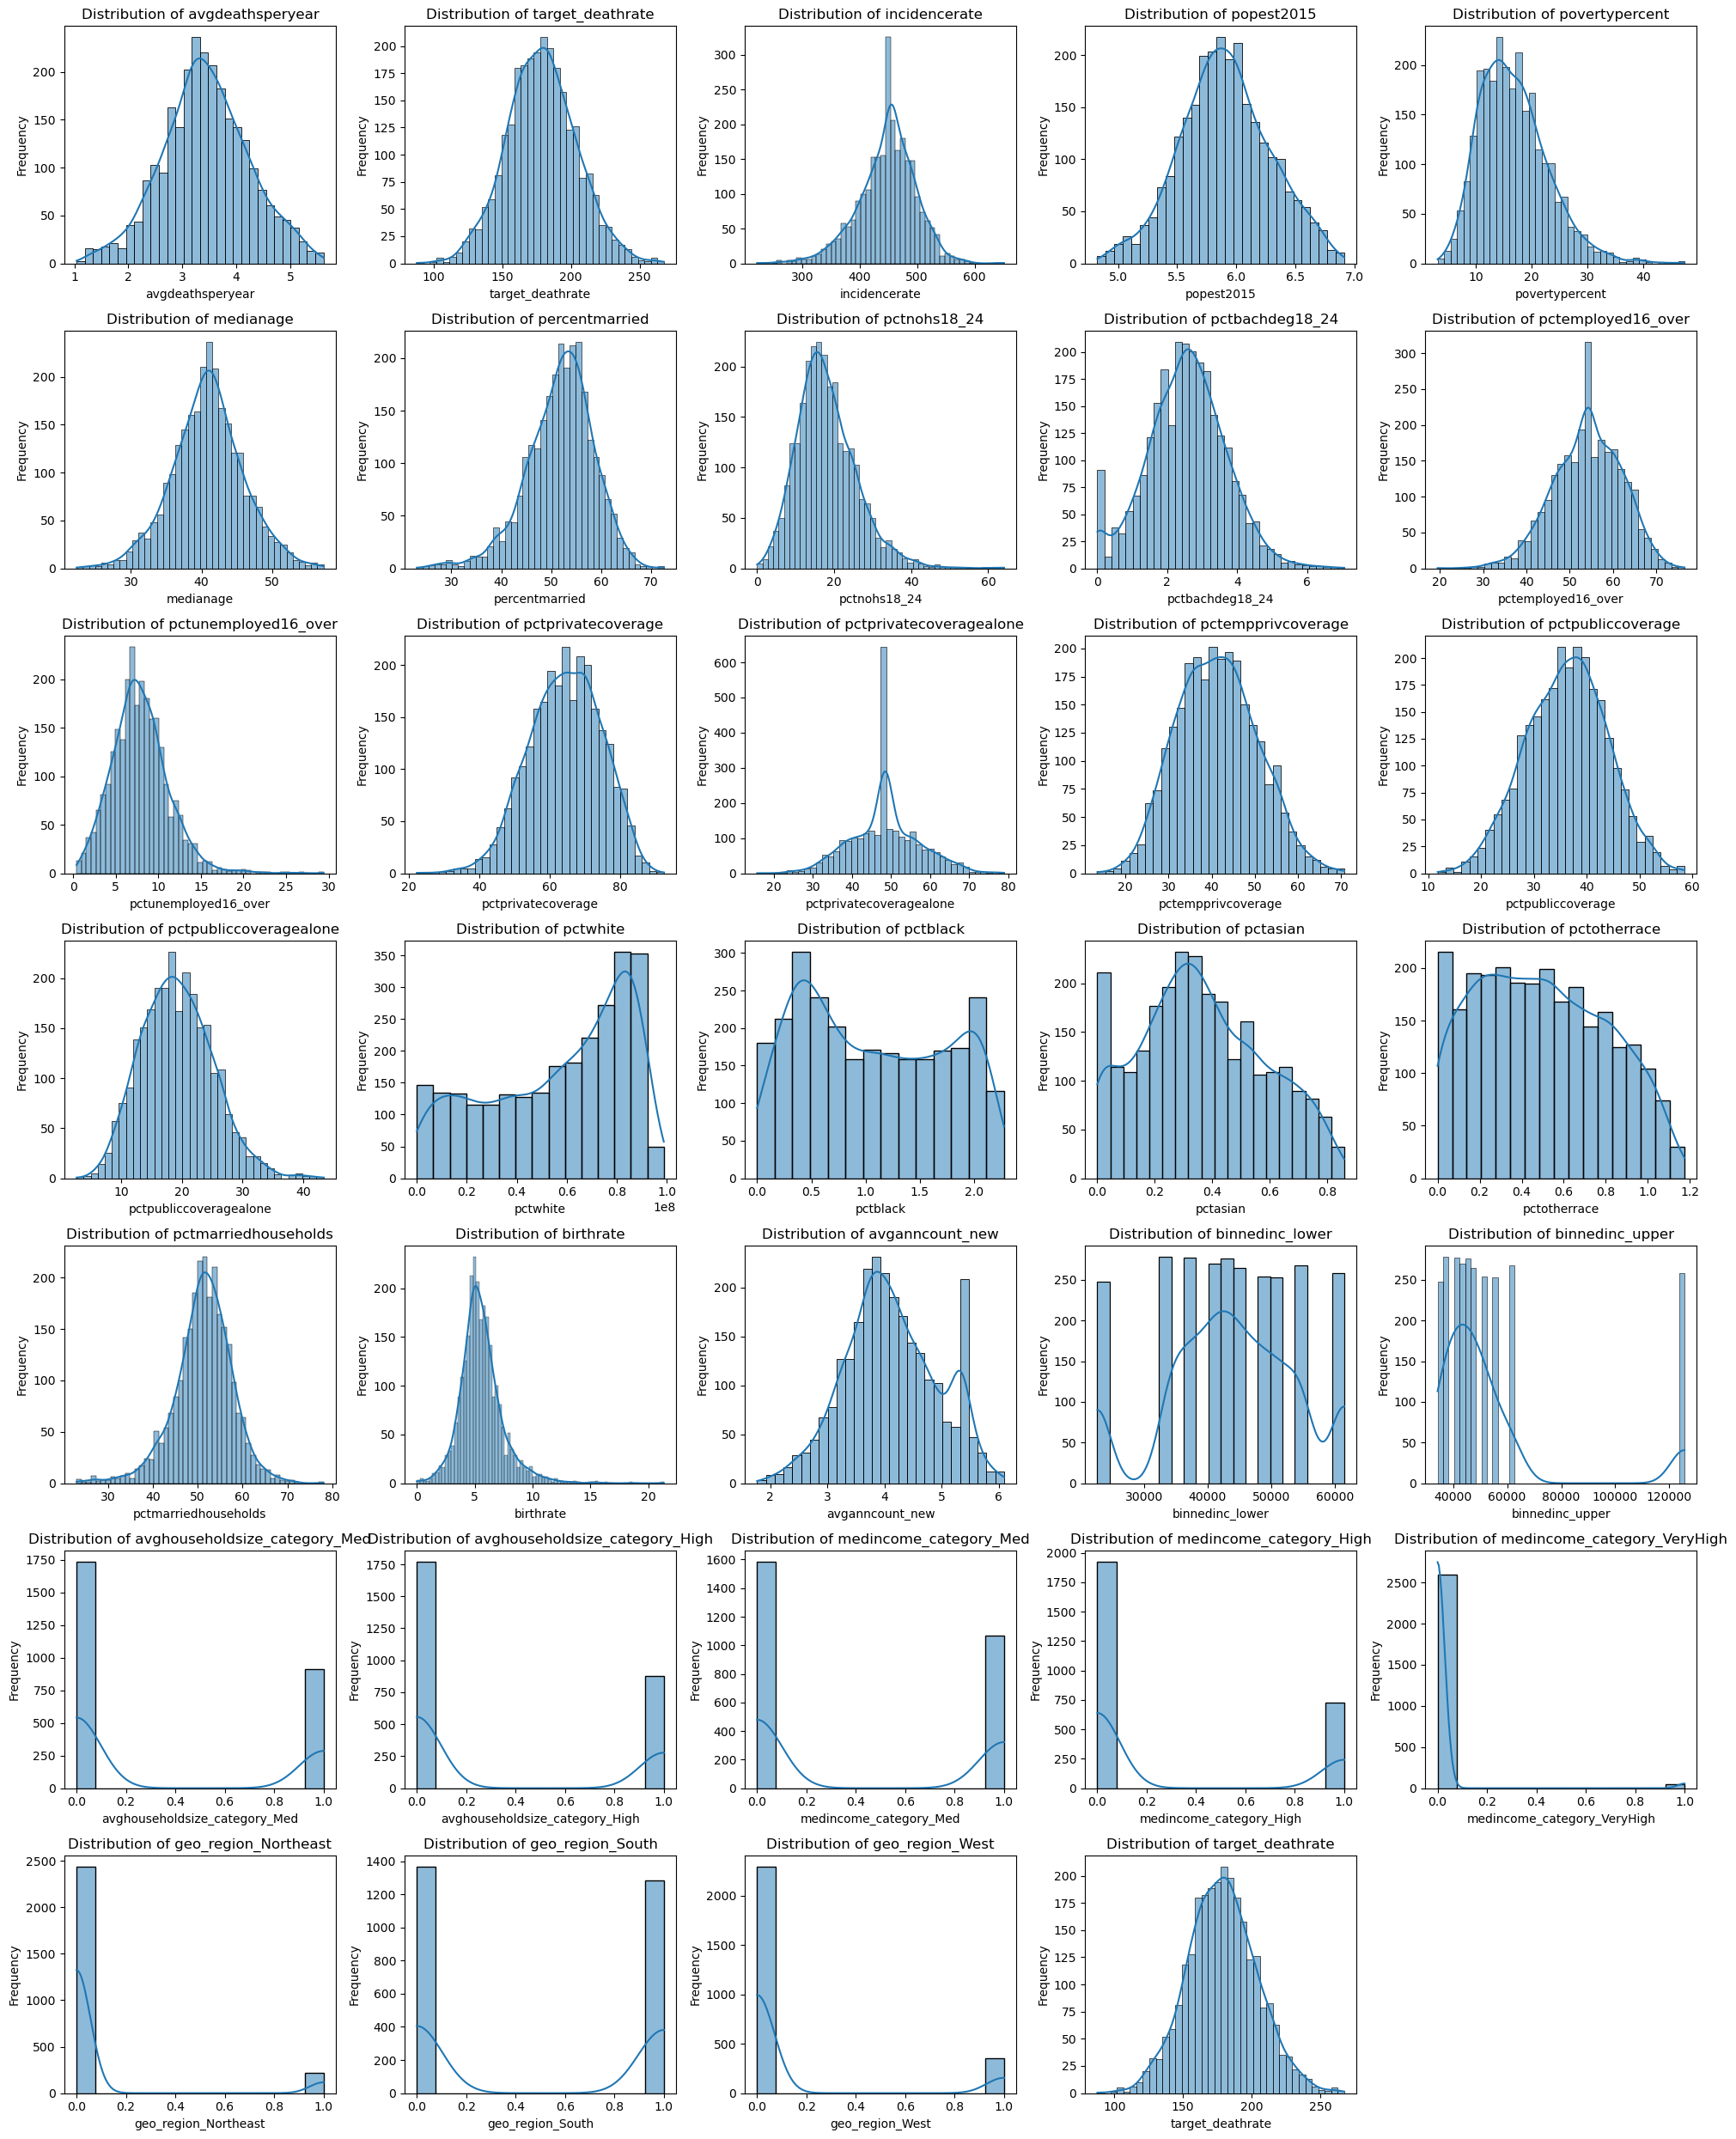

In [35]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(list(df_filtered.columns)+['target_deathrate'], 1):
    plt.subplot(7, 5, i)
    sns.histplot(df_filtered[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

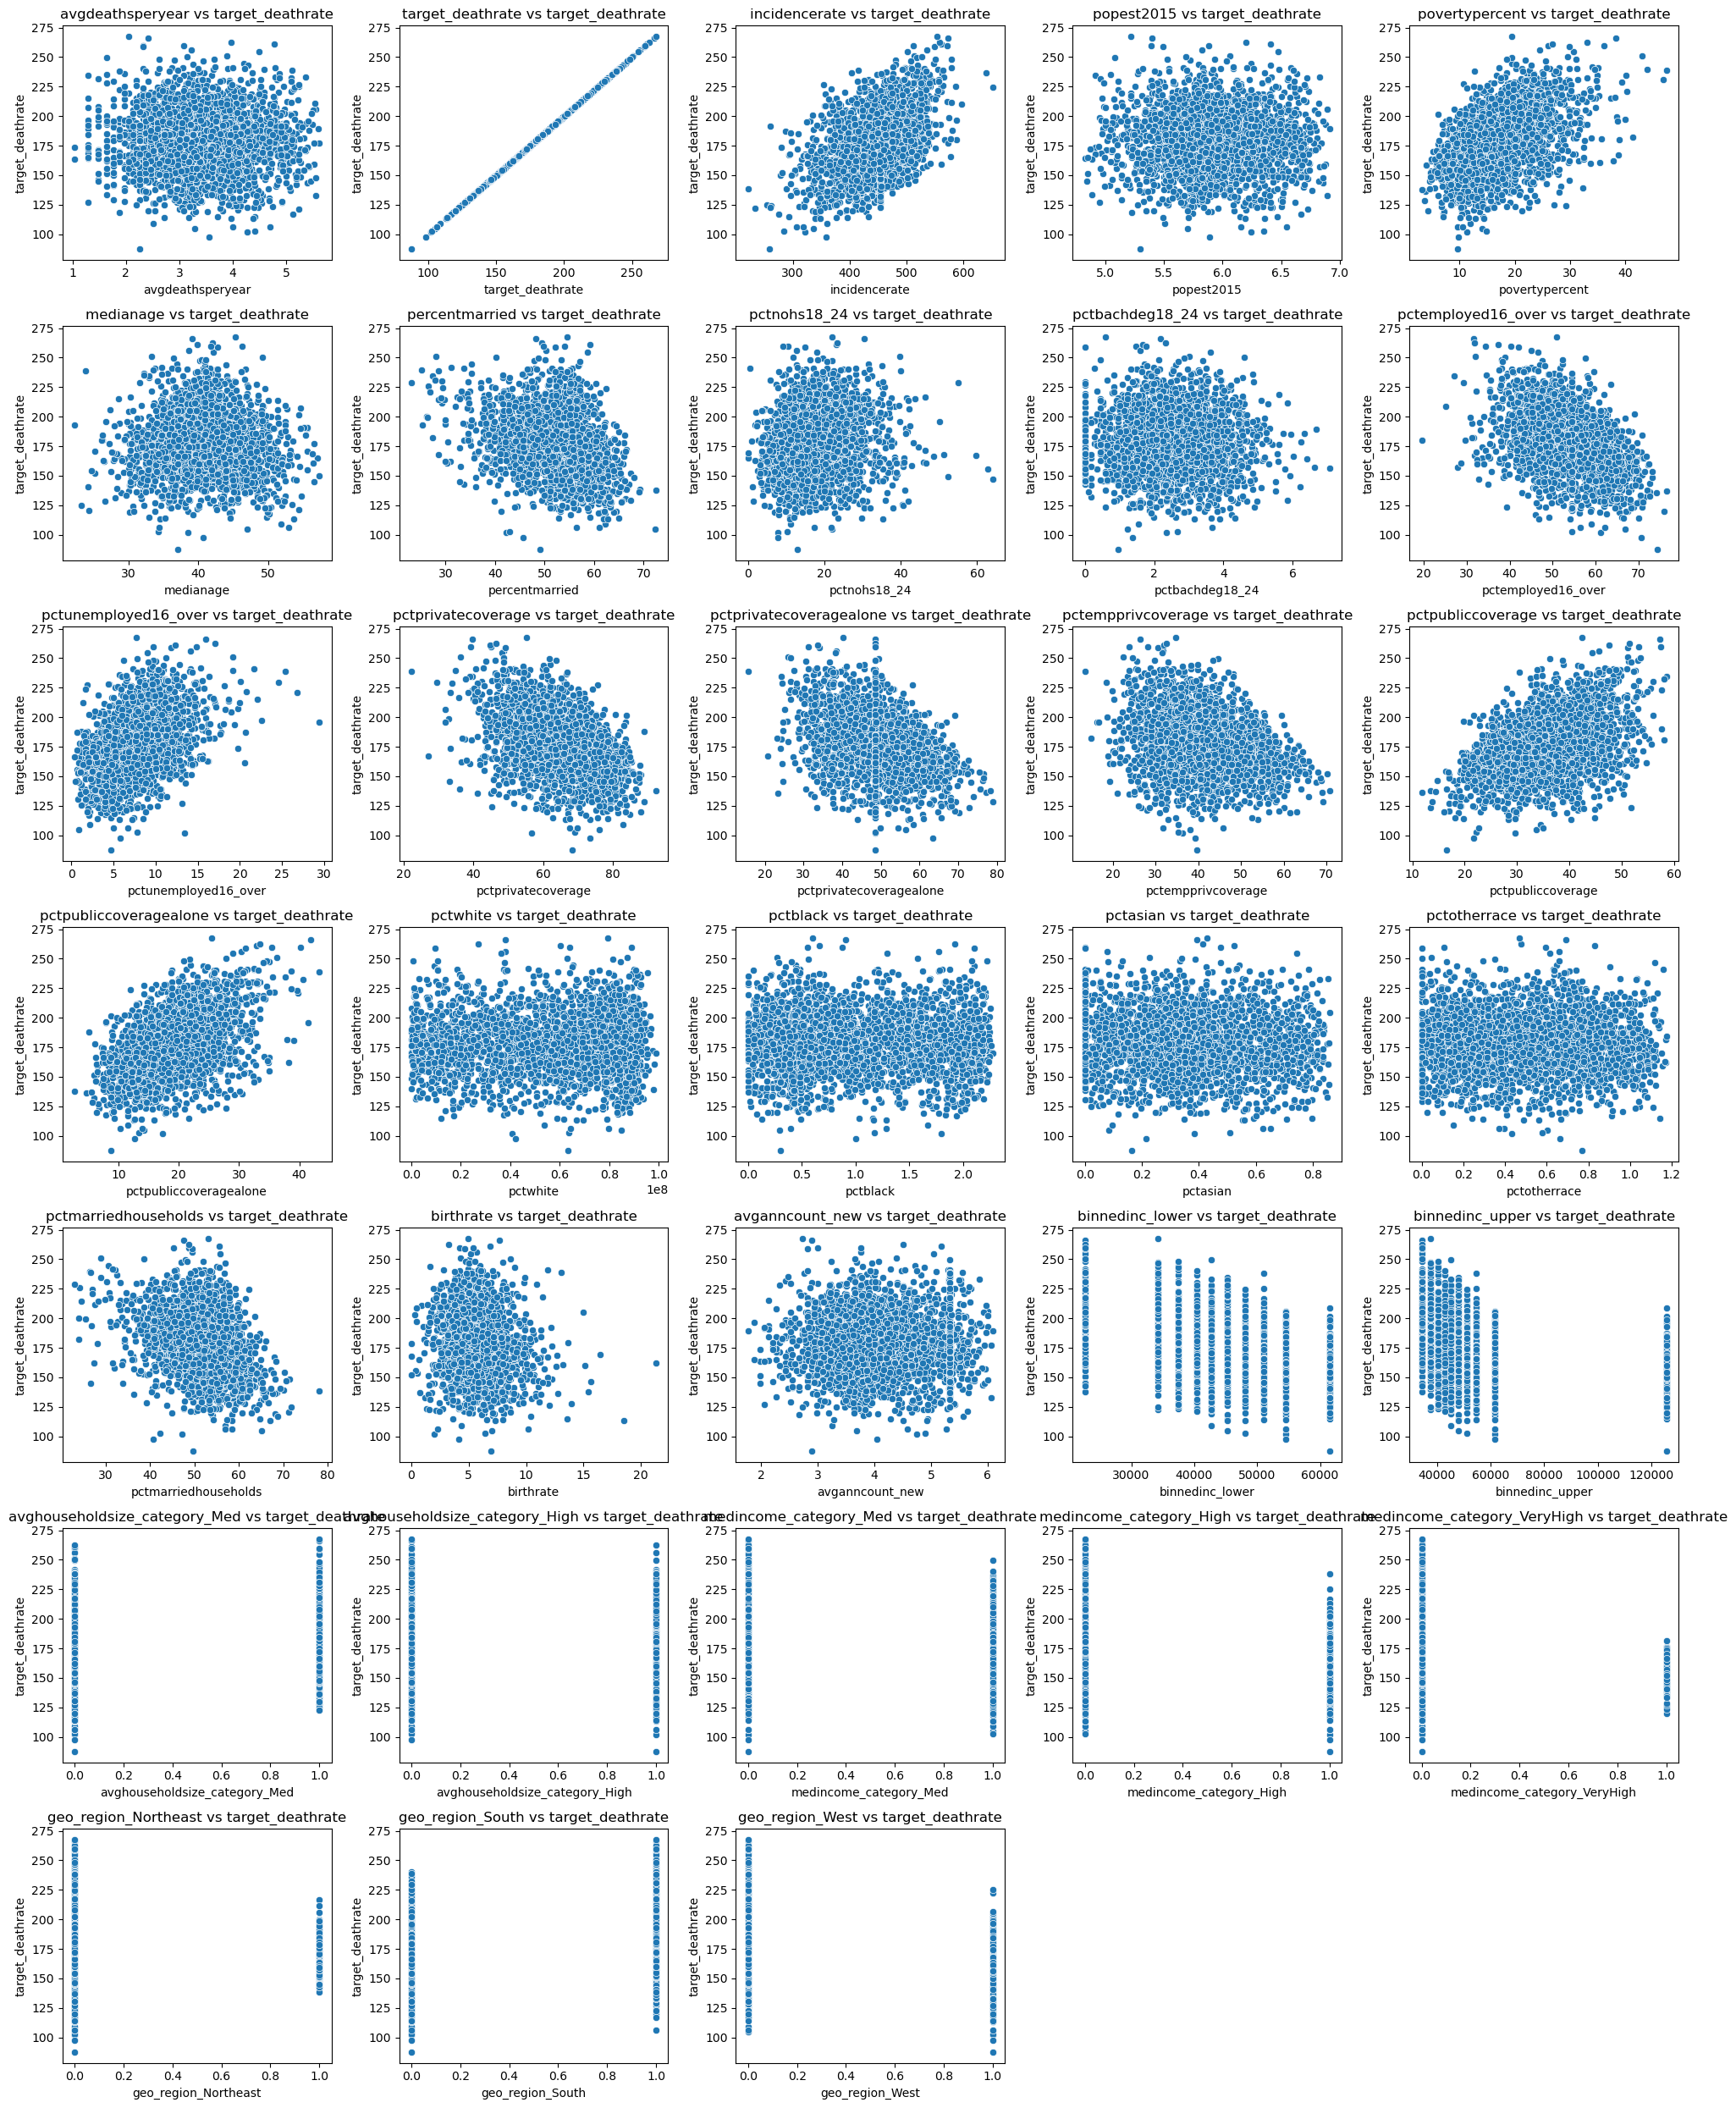

In [36]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_filtered.columns, 1):
    plt.subplot(7, 5, i)
    sns.scatterplot(x=df_filtered[col], y=df[target])
    plt.title(f'{col} vs {target}')
    plt.xlabel(col)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

## MODEL SELECTION

#### Train Test and Validation Split

In [37]:
df = df_filtered.copy()

In [38]:
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Training set: 1852
Validation set: 265
Test set: 530


In [39]:
X = train_df.drop(columns =['target_deathrate'], axis=1)  # predictors
y = train_df['target_deathrate']

In [40]:
response = 'target_deathrate'
predictors = ['avgdeathsperyear', 'incidencerate', 'popest2015',
       'povertypercent', 'medianage', 'percentmarried', 'pctnohs18_24',
       'pctbachdeg18_24', 'pctemployed16_over', 'pctunemployed16_over',
       'pctprivatecoverage', 'pctprivatecoveragealone', 'pctempprivcoverage',
       'pctpubliccoverage', 'pctpubliccoveragealone', 'pctwhite', 'pctblack',
       'pctasian', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate',
       'avganncount_new', 'binnedinc_lower', 'binnedinc_upper',
       'avghouseholdsize_category_Med', 'avghouseholdsize_category_High',
       'medincome_category_Med', 'medincome_category_High',
       'medincome_category_VeryHigh', 'geo_region_Northeast',
       'geo_region_South', 'geo_region_West']

#### Type 2 Anova to find Insignificant Predictors

In [41]:
formula = 'target_deathrate ~ ' + ' + '.join(X.columns)
full_model = smf.ols(formula, data=train_df).fit()
anova_results = sm.stats.anova_lm(full_model,typ=2)

In [42]:
anova_results

sum_sq      df           F  \
avgdeathsperyear                    60.737950     1.0    0.233332   
incidencerate                   147600.160424     1.0  567.022386   
popest2015                         265.564522     1.0    1.020196   
povertypercent                     725.387628     1.0    2.786657   
medianage                         2097.049203     1.0    8.056047   
percentmarried                    6285.482629     1.0   24.146379   
pctnohs18_24                       550.456019     1.0    2.114638   
pctbachdeg18_24                     24.357924     1.0    0.093574   
pctemployed16_over               10226.992076     1.0   39.288124   
pctunemployed16_over              1945.065493     1.0    7.472185   
pctprivatecoverage               10340.509886     1.0   39.724216   
pctprivatecoveragealone            318.515051     1.0    1.223611   
pctempprivcoverage               14977.756899     1.0   57.538714   
pctpubliccoverage                 1020.391861     1.0    3.919949   
pctpubliccoveragealone             184.699992     1.0    0.709546   
pctwhite                           958.322303     1.0    3.681501   
pctblack                             0.524479     1.0    0.002015   
pctasian                            10.634561     1.0    0.040854   
pctotherrace                       126.437080     1.0    0.485722   
pctmarriedhouseholds              6096.858522     1.0   23.421758   
birthrate                           14.003170     1.0    0.053795   
avganncount_new                     64.101712     1.0    0.246254   
binnedinc_lower                   1614.527803     1.0    6.202388   
binnedinc_upper                     65.789279     1.0    0.252737   
avghouseholdsize_category_Med     2662.362616     1.0   10.227761   
avghouseholdsize_category_High    1056.060345     1.0    4.056973   
medincome_category_Med             637.307068     1.0    2.448286   
medincome_category_High            657.707028     1.0    2.526654   
medincome_category_VeryHigh       1498.201427     1.0    5.755507   
geo_region_Northeast              9998.395960     1.0   38.409947   
geo_region_South                  1294.398026     1.0    4.972574   
geo_region_West                  31413.817805     1.0  120.679665   
Residual                        473499.280477  1819.0         NaN   

                                       PR(>F)  
avgdeathsperyear                 6.291226e-01  
incidencerate                   2.547468e-109  
popest2015                       3.126070e-01  
povertypercent                   9.522440e-02  
medianage                        4.585538e-03  
percentmarried                   9.729454e-07  
pctnohs18_24                     1.460691e-01  
pctbachdeg18_24                  7.597172e-01  
pctemployed16_over               4.555055e-10  
pctunemployed16_over             6.326643e-03  
pctprivatecoverage               3.660773e-10  
pctprivatecoveragealone          2.687994e-01  
pctempprivcoverage               5.255240e-14  
pctpubliccoverage                4.786684e-02  
pctpubliccoveragealone           3.997055e-01  
pctwhite                         5.517563e-02  
pctblack                         9.642023e-01  
pctasian                         8.398429e-01  
pctotherrace                     4.859309e-01  
pctmarriedhouseholds             1.410822e-06  
birthrate                        8.166131e-01  
avganncount_new                  6.197853e-01  
binnedinc_lower                  1.284643e-02  
binnedinc_upper                  6.152154e-01  
avghouseholdsize_category_Med    1.407217e-03  
avghouseholdsize_category_High   4.413625e-02  
medincome_category_Med           1.178272e-01  
medincome_category_High          1.121111e-01  
medincome_category_VeryHigh      1.653715e-02  
geo_region_Northeast             7.075889e-10  
geo_region_South                 2.587392e-02  
geo_region_West                  3.154146e-27  
Residual                                  NaN

In [43]:
anova_results.loc[anova_results['PR(>F)'] > 0.05]

sum_sq   df         F    PR(>F)
avgdeathsperyear          60.737950  1.0  0.233332  0.629123
popest2015               265.564522  1.0  1.020196  0.312607
povertypercent           725.387628  1.0  2.786657  0.095224
pctnohs18_24             550.456019  1.0  2.114638  0.146069
pctbachdeg18_24           24.357924  1.0  0.093574  0.759717
pctprivatecoveragealone  318.515051  1.0  1.223611  0.268799
pctpubliccoveragealone   184.699992  1.0  0.709546  0.399705
pctwhite                 958.322303  1.0  3.681501  0.055176
pctblack                   0.524479  1.0  0.002015  0.964202
pctasian                  10.634561  1.0  0.040854  0.839843
pctotherrace             126.437080  1.0  0.485722  0.485931
birthrate                 14.003170  1.0  0.053795  0.816613
avganncount_new           64.101712  1.0  0.246254  0.619785
binnedinc_upper           65.789279  1.0  0.252737  0.615215
medincome_category_Med   637.307068  1.0  2.448286  0.117827
medincome_category_High  657.707028  1.0  2.526654  0.112111

In [44]:
# list of variables that are insignificant:
anova_results.loc[anova_results['PR(>F)'] > 0.05].index

Index(['avgdeathsperyear', 'popest2015', 'povertypercent', 'pctnohs18_24',
       'pctbachdeg18_24', 'pctprivatecoveragealone', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace', 'birthrate',
       'avganncount_new', 'binnedinc_upper', 'medincome_category_Med',
       'medincome_category_High'],
      dtype='object')

In [45]:
insignificant = ['avgdeathsperyear', 'popest2015', 'povertypercent', 'pctnohs18_24',
       'pctbachdeg18_24', 'pctprivatecoveragealone', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace', 'birthrate',
       'avganncount_new', 'binnedinc_upper', 'medincome_category_Med',
       'medincome_category_High']
predictors_new = [x for x in predictors if x not in insignificant]

#### Stepwise AIC

In [46]:
## STEP AIC
def stepwise_selection_AIC(data, response, predictors):
    remaining_predictors = set(predictors)
    selected_predictors = []
    best_aic = float('inf')
    results = []

    while remaining_predictors:
        aic_with_candidates = []

        for candidate in remaining_predictors:
            model = sm.OLS(data[response], sm.add_constant(data[selected_predictors + [candidate]])).fit()
            aic_with_candidates.append((model.aic, candidate))

        aic_with_candidates.sort()
        best_new_aic, best_candidate = aic_with_candidates[0]

        if best_new_aic < best_aic:
            selected_predictors.append(best_candidate)
            remaining_predictors.remove(best_candidate)
            best_aic = best_new_aic

            formula = f"{response} ~ " + " + ".join(selected_predictors)
            results.append({'Model Formula': formula, 'AIC': best_aic})
        else:
            break 

    while selected_predictors:
        aic_without_candidates = []

        for candidate in selected_predictors:
            temp_predictors = [p for p in selected_predictors if p != candidate]
            model = sm.OLS(data[response], sm.add_constant(data[temp_predictors])).fit()
            aic_without_candidates.append((model.aic, candidate))

        aic_without_candidates.sort()
        best_new_aic, worst_candidate = aic_without_candidates[0]

        if best_new_aic < best_aic:
            selected_predictors.remove(worst_candidate)
            best_aic = best_new_aic

            formula = f"{response} ~ " + " + ".join(selected_predictors)
            results.append({'Model Formula': formula, 'AIC': best_aic})
        else:
            break 

    results_df = pd.DataFrame(results)
    return results_df

In [47]:
stepwise_results_significant_AIC = stepwise_selection_AIC(train_df, response, predictors_new)
stepwise_results_significant_AIC

Model Formula           AIC
0                  target_deathrate ~ binnedinc_lower  16663.906175
1   target_deathrate ~ binnedinc_lower + incidence...  16029.756911
2   target_deathrate ~ binnedinc_lower + incidence...  15871.576771
3   target_deathrate ~ binnedinc_lower + incidence...  15828.687213
4   target_deathrate ~ binnedinc_lower + incidence...  15750.002834
5   target_deathrate ~ binnedinc_lower + incidence...  15715.696678
6   target_deathrate ~ binnedinc_lower + incidence...  15675.239565
7   target_deathrate ~ binnedinc_lower + incidence...  15626.636715
8   target_deathrate ~ binnedinc_lower + incidence...  15618.989953
9   target_deathrate ~ binnedinc_lower + incidence...  15611.708509
10  target_deathrate ~ binnedinc_lower + incidence...  15606.075304
11  target_deathrate ~ binnedinc_lower + incidence...  15603.576836
12  target_deathrate ~ binnedinc_lower + incidence...  15602.642745
13  target_deathrate ~ binnedinc_lower + incidence...  15590.974252
14  target_deathrate ~ binnedinc_lower + incidence...  15583.684998
15  target_deathrate ~ binnedinc_lower + incidence...  15581.949298

In [48]:
idxmin = stepwise_results_significant_AIC['AIC'].idxmin()
print(f"best AIC value: {stepwise_results_significant_AIC.loc[idxmin]['AIC']}")
print(f"AIC model: {stepwise_results_significant_AIC.loc[idxmin]['Model Formula']}")

best AIC value: 15581.949298221594
AIC model: target_deathrate ~ binnedinc_lower + incidencerate + geo_region_South + geo_region_West + pctprivatecoverage + pctempprivcoverage + pctemployed16_over + geo_region_Northeast + pctpubliccoverage + pctunemployed16_over + avghouseholdsize_category_Med + medincome_category_VeryHigh + percentmarried + pctmarriedhouseholds + medianage + avghouseholdsize_category_High


#### Stepwise BIC

In [49]:
def stepwise_selection_bic(data, response, predictors):
    remaining_predictors = set(predictors)
    selected_predictors = []
    best_bic = float('inf')
    results = []

    while remaining_predictors:
        bic_with_candidates = []

        for candidate in remaining_predictors:
            model = sm.OLS(data[response], sm.add_constant(data[selected_predictors + [candidate]])).fit()
            bic_with_candidates.append((model.bic, candidate))

        bic_with_candidates.sort()
        best_new_bic, best_candidate = bic_with_candidates[0]

        if best_new_bic < best_bic:
            selected_predictors.append(best_candidate)
            remaining_predictors.remove(best_candidate)
            best_bic = best_new_bic

            formula = f"{response} ~ " + " + ".join(selected_predictors)
            results.append({'Model Formula': formula, 'BIC': best_bic})
        else:
            break  

    while selected_predictors:
        bic_without_candidates = []

        for candidate in selected_predictors:
            temp_predictors = [p for p in selected_predictors if p != candidate]
            model = sm.OLS(data[response], sm.add_constant(data[temp_predictors])).fit()
            bic_without_candidates.append((model.bic, candidate))

        bic_without_candidates.sort()
        best_new_bic, worst_candidate = bic_without_candidates[0]

        if best_new_bic < best_bic:
            selected_predictors.remove(worst_candidate)
            best_bic = best_new_bic

            formula = f"{response} ~ " + " + ".join(selected_predictors)
            results.append({'Model Formula': formula, 'BIC': best_bic})
        else:
            break 

    results_df = pd.DataFrame(results)
    return results_df

In [50]:
stepwise_results_significant_BIC = stepwise_selection_bic(train_df, response, predictors_new)
stepwise_results_significant_BIC

Model Formula           BIC
0                  target_deathrate ~ binnedinc_lower  16674.954218
1   target_deathrate ~ binnedinc_lower + incidence...  16046.328976
2   target_deathrate ~ binnedinc_lower + incidence...  15893.672856
3   target_deathrate ~ binnedinc_lower + incidence...  15856.307320
4   target_deathrate ~ binnedinc_lower + incidence...  15783.146962
5   target_deathrate ~ binnedinc_lower + incidence...  15754.364828
6   target_deathrate ~ binnedinc_lower + incidence...  15719.431737
7   target_deathrate ~ binnedinc_lower + incidence...  15676.352908
8   target_deathrate ~ binnedinc_lower + incidence...  15674.230167
9   target_deathrate ~ binnedinc_lower + incidence...  15672.472745
10  target_deathrate ~ binnedinc_lower + incidence...  15672.363561
11  target_deathrate ~ binnedinc_lower + incidence...  15669.990285
12  target_deathrate ~ binnedinc_lower + incidence...  15668.133229

In [51]:
idxmin = stepwise_results_significant_BIC['BIC'].idxmin()
print(f"best BIC value: {stepwise_results_significant_BIC.loc[idxmin]['BIC']}")
print(f"BIC model: {stepwise_results_significant_BIC.loc[idxmin]['Model Formula']}")

best BIC value: 15668.133228999697
BIC model: target_deathrate ~ binnedinc_lower + incidencerate + geo_region_West + pctprivatecoverage + pctempprivcoverage + pctemployed16_over + geo_region_Northeast + pctunemployed16_over + avghouseholdsize_category_Med


#### Getting MPSE on Validation Set:

In [52]:
AIC_model = smf.ols('target_deathrate ~ binnedinc_lower + incidencerate + geo_region_South +\
 geo_region_West + pctprivatecoverage + pctempprivcoverage + pctemployed16_over +\
  geo_region_Northeast + pctpubliccoverage + pctunemployed16_over + avghouseholdsize_category_Med +\
   medincome_category_VeryHigh + percentmarried + pctmarriedhouseholds +\
    medianage + avghouseholdsize_category_High', data=train_df).fit()

In [53]:
BIC_model = smf.ols('target_deathrate ~ binnedinc_lower + incidencerate + geo_region_West +\
 pctprivatecoverage + pctempprivcoverage + pctemployed16_over + geo_region_Northeast +\
  pctunemployed16_over + avghouseholdsize_category_Med', data=train_df).fit()

In [54]:
X_val = val_df.drop(columns =['target_deathrate'], axis=1)
y_val = val_df['target_deathrate']

In [55]:
y_pred = AIC_model.predict(sm.add_constant(X_val))
mpse = mean_squared_error(y_val, y_pred)

print("MPSE on validation set for AIC Model:", mpse)

MPSE on validation set for AIC Model: 243.34143969958944


In [56]:
y_pred = BIC_model.predict(sm.add_constant(X_val))
mpse = mean_squared_error(y_val, y_pred)

print("MPSE on validation set for BIC Model:", mpse)

MPSE on validation set for BIC Model: 249.0320624465024


#### $R^2_{adj}$ when Fitted on Validation Set:

In [57]:
AIC_model_val = smf.ols('target_deathrate ~ binnedinc_lower + incidencerate + geo_region_South +\
 geo_region_West + pctprivatecoverage + pctempprivcoverage + pctemployed16_over +\
  geo_region_Northeast + pctpubliccoverage + pctunemployed16_over + avghouseholdsize_category_Med +\
   medincome_category_VeryHigh + percentmarried + pctmarriedhouseholds +\
    medianage + avghouseholdsize_category_High', data=val_df).fit()

In [58]:
BIC_model_val = smf.ols('target_deathrate ~ binnedinc_lower + incidencerate + geo_region_West +\
 pctprivatecoverage + pctempprivcoverage + pctemployed16_over + geo_region_Northeast +\
  pctunemployed16_over + avghouseholdsize_category_Med', data=val_df).fit()

In [59]:
print("Adjusted R-squared for AIC Model Val:", AIC_model_val.rsquared_adj)

Adjusted R-squared for AIC Model Val: 0.6141829399196173


In [60]:
print("Adjusted R-squared for BIC Model Val:", BIC_model_val.rsquared_adj)

Adjusted R-squared for BIC Model Val: 0.6109761701099812


## Result on Test Data

In [61]:
X_test = test_df.drop(columns =['target_deathrate'], axis=1)
y_test = test_df['target_deathrate']

In [62]:
y_pred_test = AIC_model.predict(sm.add_constant(X_test))
mpse_test = mean_squared_error(y_test, y_pred_test)

print("MPSE on test set for AIC Model:", mpse_test)

MPSE on test set for AIC Model: 277.7587508650751


In [63]:
AIC_model_test = smf.ols('target_deathrate ~ binnedinc_lower + incidencerate + geo_region_South +\
 geo_region_West + pctprivatecoverage + pctempprivcoverage + pctemployed16_over +\
  geo_region_Northeast + pctpubliccoverage + pctunemployed16_over + avghouseholdsize_category_Med +\
   medincome_category_VeryHigh + percentmarried + pctmarriedhouseholds +\
    medianage + avghouseholdsize_category_High', data=test_df).fit()

In [64]:
print("Adjusted R-squared for AIC Model Test:", AIC_model_test.rsquared_adj)

Adjusted R-squared for AIC Model Test: 0.5736617562231978


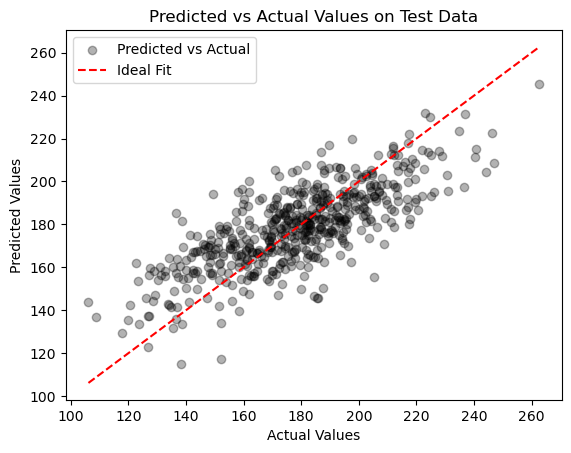

In [65]:
plt.scatter(y_test, y_pred_test, color='black', label='Predicted vs Actual', alpha=0.3)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', label='Ideal Fit', linestyle='--')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values on Test Data')

plt.legend()

plt.show()

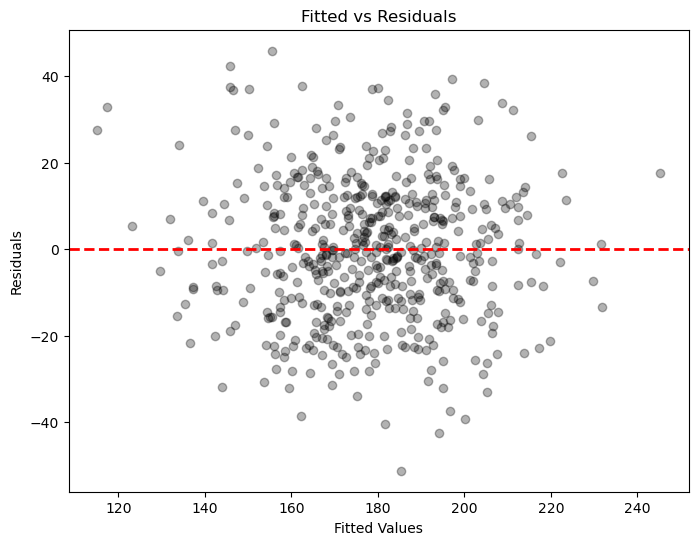

In [66]:
residuals = AIC_model_test.resid

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.3, color= 'black')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted vs Residuals')
plt.show()

In [67]:
residuals.mean() ## very close to 0.

2.9521039700825296e-14

## Model Summary

In [69]:
print(AIC_model.summary())

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     168.9
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:17:38   Log-Likelihood:                -7774.0
No. Observations:                1852   AIC:                         1.558e+04
Df Residuals:                    1835   BIC:                         1.568e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [70]:
print(BIC_model.summary())

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     289.2
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:27:40   Log-Likelihood:                -7796.4
No. Observations:                1852   AIC:                         1.561e+04
Df Residuals:                    1842   BIC:                         1.567e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     